# Variational Quantum Algorithm

### Applying VQA on a simple given Hamiltonian system to determine ground state and ground state energy

In [1]:
# General imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Aer Simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# NumpyEigenSolver from qiskit algorithms
from qiskit_algorithms import NumPyMinimumEigensolver

Defining Hamiltonian for the system $ H = X \otimes X + Y \otimes Y + Z \otimes I$

In [2]:
hamiltonian = SparsePauliOp.from_list([("XX", 1), ("YY", 1), ("ZI", 1)])

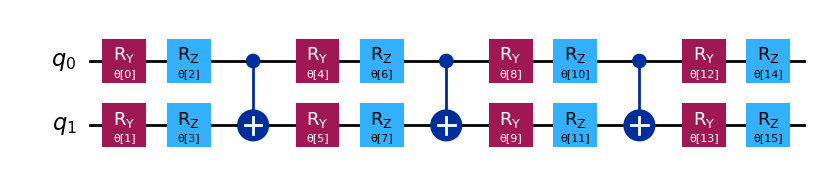

In [ ]:
# Generating a general Ansatz to start with
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [4]:
num_params = ansatz.num_parameters
print(num_params)

16


In [6]:
# Define Aer simulator backend
backend = AerSimulator()
estimator = EstimatorV2( 
    options=
    {
        "run_options": {"shots": 1024, "seed": 28}
    }
)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

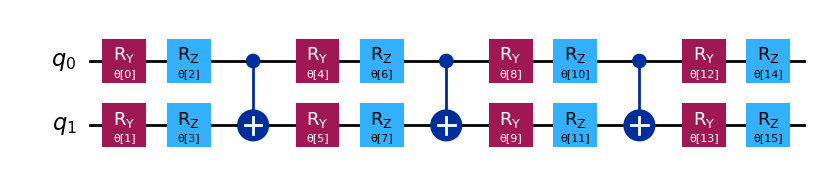

In [8]:
# Optimized Ansatz
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [9]:
# Initialising the system
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [10]:
# Cost History Dictionary
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [12]:
# Initial State
x0 = 2 * np.pi * np.random.random(num_params)

print(x0)

[5.50414252 4.05145548 0.78326912 4.62349125 2.41619167 3.72013036
 2.45169537 5.98455228 4.53718604 5.12140453 4.74144456 0.0890046
 3.35778308 3.46505769 6.26315285 1.80310499]


In [13]:
# Perform the optimization using Aer simulator
res = minimize(
    cost_func,  # Function to minimize
    x0,  # Initial guess for parameters
    args=(ansatz_isa, hamiltonian_isa, estimator),  # Arguments for cost function
    method="COBYLA",  # Optimization method
)         

Iters. done: 1 [Current cost: 0.4745697767685759]
Iters. done: 2 [Current cost: 1.1083555482983618]
Iters. done: 3 [Current cost: 0.554309171559555]
Iters. done: 4 [Current cost: 0.8595390322044674]
Iters. done: 5 [Current cost: 0.22970128694884595]
Iters. done: 6 [Current cost: -0.019152795326967786]
Iters. done: 7 [Current cost: -0.6870984520909343]
Iters. done: 8 [Current cost: -0.9922544213044553]
Iters. done: 9 [Current cost: -0.5728333922688622]
Iters. done: 10 [Current cost: -0.23515772320652129]
Iters. done: 11 [Current cost: -0.002486889117591984]
Iters. done: 12 [Current cost: -0.5182491388973957]
Iters. done: 13 [Current cost: -0.6893294959164653]
Iters. done: 14 [Current cost: -0.7584889933985909]
Iters. done: 15 [Current cost: -1.4767128552463058]
Iters. done: 16 [Current cost: -1.3044617671847396]
Iters. done: 17 [Current cost: -0.4471079220303159]
Iters. done: 18 [Current cost: -1.3311131511409737]
Iters. done: 19 [Current cost: -1.181370692713037]
Iters. done: 20 [Curre

In [15]:
# Post processing data
print(res)
all(cost_history_dict["prev_vector"] == res.x)
cost_history_dict["iters"] == res.nfev

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.2360679662830893
       x: [ 5.639e+00  4.150e+00 ...  6.700e+00  1.213e+00]
    nfev: 306
   maxcv: 0.0


True

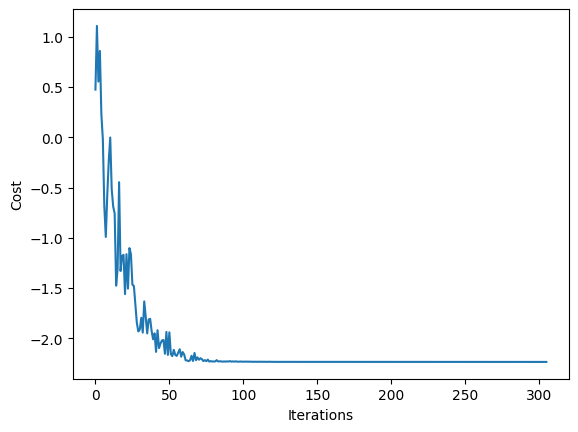

In [16]:
# Plotting cost vs iterations
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

Using Minimum Eigenvalue Solver

In [107]:
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(hamiltonian)

Analysis of the results from both the methods use!

In [108]:
print('Optimized ground state energy:', res.fun)
print('Exact ground state energy:', exact_result.eigenvalue.real)
print('Energy Difference:', abs(exact_result.eigenvalue.real - res.fun))

Optimized ground state energy: -2.23606795588046
Exact ground state energy: -2.2360679774997885
Energy Difference: 2.1619328549604688e-08


The ground state energy obtained from both the methods is approximately the same, error being of nano order.\
$ E_g = -2.23606 \,\text{eV}$